#Handwritten Digit Classification

  * We are going to use **perceptron classifier** to classify (recognize) given digit images. Since a single perceptron could only be used for binary classification, we consider only two classes in the first half.

  * we want to recognize whether the given image is of digit zero or not (digits other than zero).

  * The first step is to create a dataset that contains a collection of digit images (also called examples, samples) written by humans. Then each image should be labelled properly.
  
  * we have **MNIST**.

# Imports (slide 6.1 )
* Import all necessary packages.For classification problems, we need to import classes and utilities from `sklearn.linear_model`.  
*  This module has implementations for different classification models like `Perceptron, LogisticRegression, svm` and `knn`


The data preprocessing utilities are imported from `sklearn.preprocessing` modules.

In [ ]:
import numpy as np
import os
import io
import warnings

#sklearn specific imports
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from pprint import pprint

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#global matplotlib settings
mpl.rc('figure',figsize=(8,6))
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# to make this notebook's output stable across runs
np.random.seed(42)

#import cv lib to process real world example
import cv2

Following definition helps us supress some warning messages. (**Warning:** we are purposefully supressing the warnings, not a good idea in general!).

In [ ]:
# Ignore all warnings (like convergence..) by sklearn
def warn(*args, **kwargs):
    pass
warnings.warn = warn

## Data Loading and preprocessing (slide 6.2)

In [ ]:
X,y= fetch_openml('mnist_784',version=1,return_X_y=True)
#it returns Data and label as a pandas dataframe

X = X.to_numpy()
y = y.to_numpy()

The data matrix $X$ and the respective label vector $y$ need to be converted to the numpy array by calling a `to_numpy` method.

In [ ]:
X = X.to_numpy()
y = y.to_numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

* Let's get some information like number of features,number of classes about the dataset.
* Observe that the labels are of string data type not integers.

In [ ]:
# X,y= fetch_openml('mnist_784',version=1,return_X_y=True)
#it returns Data and label as a pandas dataframe

# X = X.to_numpy()
# y = y.to_numpy()

target_names = np.unique(y)
print('Number of samples: {0}, type:{1}'.format(X.shape[0],X.dtype))
print('Number of features: {0}'.format(X.shape[1]))
print('Minimum:{0},Maximum:{1}'.format(np.min(X),np.max(X)))
print('Number of classes: {0}, type:{1}'.format(len(target_names),y.dtype))
print('Labels: {0}'.format(target_names))

Number of samples: 70000, type:int64
Number of features: 784
Minimum:0,Maximum:255
Number of classes: 10, type:object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


* The MNIST dataset is clean and the range of values that each feature can take is also known. Therefore, the samples in the dataset may not require many data preprocessing techniques.
* However, it is often better to scale the range of features between 0 to 1.
* So, we can either use `MinMaxScaler` or `MaxAbsScaler`.They don't make any difference as the image pixels can takes only positive values from 0 to 255.


In [ ]:
X = MinMaxScaler().fit_transform(X)
print("Minimum:{0},Maximum:{1}".format(np.min(X),np.max(X)))

Minimum:0.0,Maximum:1.0


## **Data Visualization**
Let us pick a few images (the images are already shuffled in the dataset) and display them with their respective labels. As said above, the images are stacked as a row vector of size $1 \times 784$ and therefore must be reshaped to the matrix of size $28 \times 28$  to display them properly.

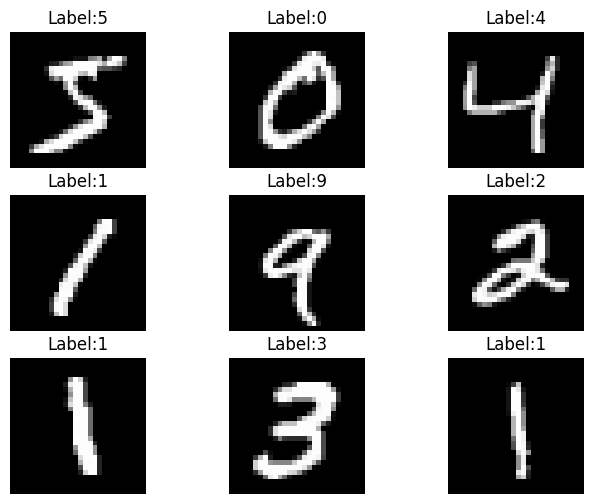

In [ ]:
num_images = 9
factor = np.int64(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset = 0
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y[index+j])))
    ax[i,j].set_axis_off()

If you closely observe, you can see that there are moderate variations in the appearance of digits (say, digit:1). These matrices are also close to sparse (that is, there are lots of 0 (black pixels) in the matrix than non-zero pixels).

It is always a good practice to inspect the image pixel values closely and ask some interesting questions such as.

1.   What is the range of pixel values?
2.   Are the pixel values highly correlated?
3.   Is the data sparse?
4.   What is the range of values that a single pixel(element) can take?
5.   Do we need to apply any pre-processing methods?

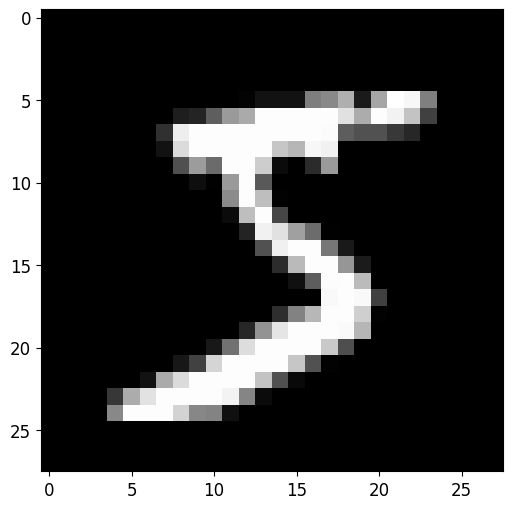

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(X[0].reshape(28,28),cmap='gray')
plt.show()

## Data Splitting

* Now, we know the details such as number of samples, size of each sample, number of
features (784), number of classes (targets)  about the dataset.

* So let us spilt the total number of samples into train and test set in the following ratio: 60000/10000 (that is, 60000 samples in the training set and 10000 samples in the testing set).


In [ ]:
x_train,x_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

Before procedding further, we need to check whether the dataset is balanced or imbalanced. We can do it by plotting the distribution of samples in each classes.

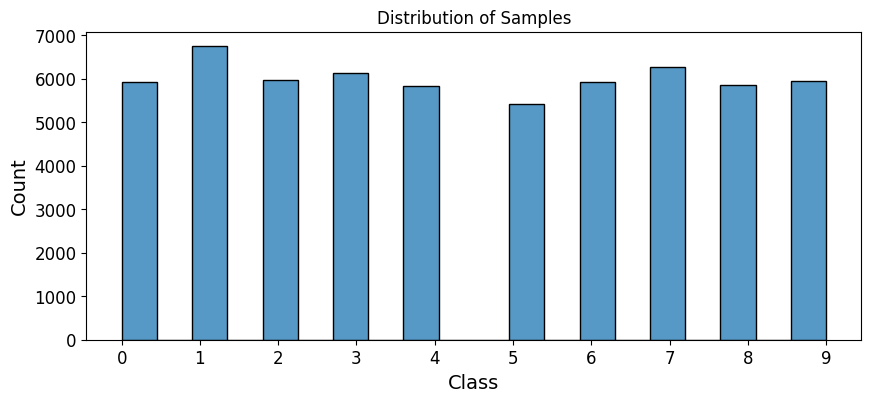

In [ ]:
x_train,x_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

plt.figure(figsize=(10,4))
sns.histplot(data=np.int8(y_train),binwidth=0.45,bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9],labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of Samples')
plt.show()

#Binary Classification : 0-Detector

## Modifying Labels
* Let us start with a simple classification problem, that is, binary classification.
* Since the original label vector contains **10** classes, we need to modfiy the number of classes to **2**

* Therefore,  the label **0** will be changed to **1** and all other labels (1-9) will be changed to **-1**.

* We name the label vectors as `y_train_0` and `y_test_0 `.

In [ ]:
# intialize new variable names with all -1
y_train_0 = -1*np.ones((len(y_train)))
y_test_0 = -1*np.ones((len(y_test)))

# find indices of digit 0 image
indx_0 = np.where(y_train =='0') # remember original labels are of type str not int
# use those indices to modify y_train_0&y_test_0
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

## Sanity check
* Let's display the elements of `y_train` and `y_train_0` to verify whether the labels are properly modified.

In [ ]:
print(y_train)   # 10 class labels
print(y_train_0) # modified binary labels

['5' '0' '4' ... '5' '6' '8']
[-1.  1. -1. ... -1. -1. -1.]


In [ ]:
print(np.where(y_train=='0')) # index of label 0's in original vector y
print(np.where(y_train_0 == 1)) # index of pos class in new vector

(array([    1,    21,    34, ..., 59952, 59972, 59987]),)
(array([    1,    21,    34, ..., 59952, 59972, 59987]),)


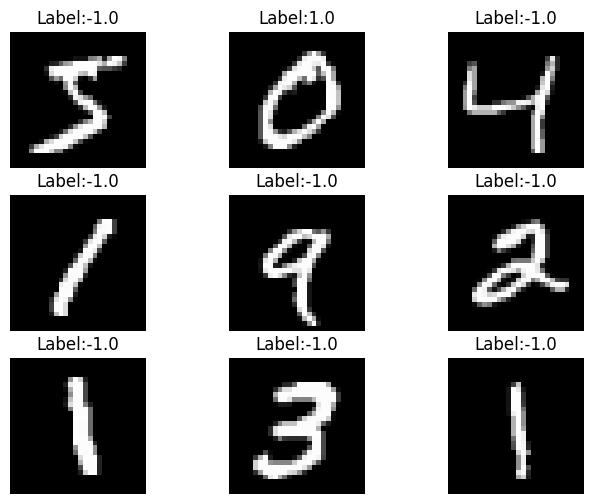

In [ ]:
num_images = 9 # Choose a square number
factor = np.int64(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y_train_0[index+j])))
    ax[i,j].set_axis_off()

In [ ]:
num_pos = len(np.where(y_train_0==1)[0])
num_neg = len(np.where(y_train_0==-1)[0])
print(num_pos,num_neg)

5923 54077


#Perceptron model


1.   List item
2.   List item



## Theory
1.  **Training data**: (features, label) or $(\mathbf{X}, y)$, where label $y$ is a **discrete** number from a finite set.**Features** in this case are pixel values of an image.
2. **Model :** \begin{eqnarray}
  h_{\mathbf{w}}: y &=& \mathrm{g}(\mathbf{w}^T \mathbf{x}) \\
    &=& \mathrm{g}(w_0 + w_1 x_1 + \ldots + w_m x_m)
\end{eqnarray}
where,
  * $\mathbf{w}$ is a weight vector in $\mathbb{R}^{(m+1)}$ i.e. it has components: $\{w_0, w_1, \ldots, w_m\}$
  * $\mathrm{g}(.)$ is a non-linear activation function given by a signum function:
\begin{equation}
  \mathrm{g}(z) =\left\{
  \begin{array}{@{}ll@{}}
    +1, & \text{if}\ z \ge 0 \\
    -1, & \text{otherwise (i.e. } z < 0)
  \end{array}\right.
\end{equation}
3.**Loss function:**
Let $\widehat{y^{(i)}} \in \{-1, +1\}$ be the prediction from perceptron and $y^{(i)}$ be the actual label for $i$-th example.  The error is
\begin{equation}
  e^{(i)} =\left\{
  \begin{array}{@{}ll@{}}
    0, & \text{if}\ \widehat{y^{(i)}} = y^{(i)} \\
    -\mathbf{w}^T \mathbf{x}^{(i)}y^{(i)}, & \text{otherwise (i.e. }\widehat{y^{(i)}} \neq y^{(i)} )
  \end{array}\right.
\end{equation}

  This can be compactly written as:
\begin{equation}
  e^{(i)} = \mathrm{max}(-\mathbf{w}^T \mathbf{x}^{(i)}y^{(i)}, 0)
          = \mathrm{max}(-h_{\mathbf{w}}(\mathbf{x}^{(i)})y^{(i)}, 0)
\end{equation}
4.**Optimization:**
  * Perceptron learning algorithm
  
  1. Initialize $\mathbf{w}^{(0)} = \mathbf{0}$
  2. For each training example $\left(\mathbf{x}^{(i)}, y^{(i)} \right)$:
    * $\hat{y}^{(i)} = \mathrm{sign}\left(\mathbf{w}^T \mathbf{x}^{(i)}\right)$   [Calculate the output value]
    * $\mathbf{w}^{(t+1)} := \mathbf{w}^{(t)} + \alpha (y^{(i)} - \hat{y}^{(i)})\ \mathbf{x}^{(i)}$  [Update the weights]

  > Linearly separable examples lead to convergence of the algorithm with zero training loss, else it oscillates.

## Training and Prediction (slide 6.3)


## Instantiation
* lets Create an instantance of binary classifier (bin_clf) and call the `fit` method to train the model.

In [ ]:
bin_clf = Perceptron(max_iter=100,random_state=1729)

* Call the `fit` method to train the model

In [ ]:
bin_clf.fit(x_train,y_train_0)
print('Dimention of Weights w: {0}'.format(bin_clf.coef_.shape))
print('Bias :{0}'.format(bin_clf.intercept_))
print('The loss function: {0}'.format(bin_clf.loss_function_))

Dimention of Weights w: (1, 784)
Bias :[-1608.]


AttributeError: 'Perceptron' object has no attribute 'loss_function_'

Let us make  predictions on the train set and then calculate the training accuracy.

In [ ]:
y_hat_train_0 = bin_clf.predict(x_train)
print('Training Accuracy: ',bin_clf.score(x_train,y_train_0))

Training Accuracy:  0.9904833333333334


Now on the Test set

In [ ]:
print('Test accuracy: ',bin_clf.score(x_test,y_test_0))

Test accuracy:  0.989


## Displaying predictions
* Taking few images from the testset at random and display it with the corresponding predictions.

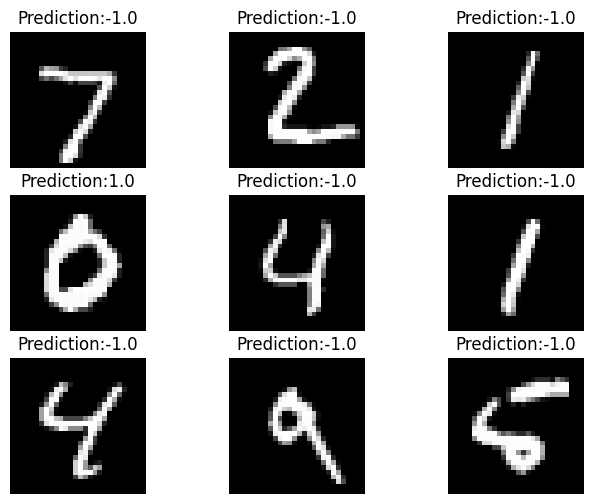

In [ ]:
y_hat_test_0 = bin_clf.predict(x_test)
num_images = 9 # Choose a square number
factor = np.int64(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset = 0 # display "num_images" starting from idx_offset
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(x_test[index+j].reshape(28,28),cmap='gray') # we should not use x_train_with_dummy

    ax[i,j].set_title('Prediction:{0}'.format(str(y_hat_test_0[index+j])))
    ax[i,j].set_axis_off()

* Display images of positive classes from testset along with their predictions.

In [ ]:
indx_0 = np.where(y_test_0 == 1)

In [ ]:
zeroImgs = x_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0[0]]
num_images = 9 # Choose a square number
factor = np.int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset = 0 # display "num_images" starting from idx_offset
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(zeroImgs[index+j].reshape(28,28),cmap='gray') # we should not use x_train_with_dummy
    ax[i,j].set_title('Prediction:{0}'.format(str(zeroLabls[index+j])))
    ax[i,j].set_axis_off()

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

It seems that there are a significant number of images that are correctly classified. Let's see how many?

In [ ]:
num_misclassified = np.count_nonzero(zeroLabls== -1)
num_correctpred = len(zeroLabls)-num_misclassified
accuracy = num_correctpred/len(zeroLabls)
print(accuracy)

0.9418367346938775


# REAL WORLD SAMPLE TEST ( Slide 6.4 )




Non-Zero


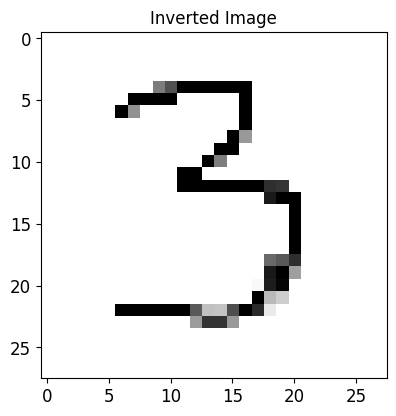

In [ ]:

# Load the image
image = cv2.imread('/content/download (3).png')

# Resize the image to 28x28 pixels
resized_image = cv2.resize(image, (28, 28))

# Convert the image to grayscale
gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

# Invert the grayscale image
inverted_image = 255 - gray_image

# Flatten the inverted image to a 1D array
flattened_image = inverted_image.flatten()

# Reshape the flattened image into a 2D array with a single sample
sample = flattened_image.reshape(1, -1)

# Predict using the trained perceptron model
prediction = bin_clf.predict(sample)
# print(type(prediction))
# print(str(prediction[0])=='1.0')
if str(prediction[0])=='1.0':
  result = 'Zero Detected'
else:
  result = 'Non-Zero'
print(result)
# print("Predicted digit:", prediction[0])

# Plot the inverted image as a vector of pixel values
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(inverted_image, cmap='gray')
plt.title('Inverted Image')



plt.tight_layout()
plt.show()

#SCOPE   Multiclass Classifier ( slide 6.5 )
Combine multiple binary classifiers and devise a suitable scoring metric.


In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelBinarizer

In [ ]:
clf = Perceptron(random_state=1729)
clf.fit(x_train,y_train)

Perceptron(random_state=1729)

In [ ]:
y_train_ovr = LabelBinarizer().fit_transform(y_train)
for i in range(10):
  print('{0}:{1}'.format(y_train[i],y_train_ovr[i]))

5:[0 0 0 0 0 1 0 0 0 0]
0:[1 0 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
9:[0 0 0 0 0 0 0 0 0 1]
2:[0 0 1 0 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
3:[0 0 0 1 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]


* The `y_train_ovr` will be of size of size $60000 \times 10$.
* The first column will be a (binary) label vector for 0-detector 😀 and the next one for 1-Detector and so on.


In [ ]:
clf.fit(x_train,y_train)

Perceptron(random_state=1729)

* What had actually happened internally was that the API automatically created 10 binary classifiers, converted labels to binary sparse matrix and trained them with the binarized labels!.
*  During the inference time, the input will be passed through all these 10 classifiers and the highest score among the ouput from the classifiers will be considered as the predicted class.
* To see it in action, let us execute the following lines of code

In [ ]:
print('Shape of Weight matrix:{0} and bias vector:{1}'.format(clf.coef_.shape,clf.intercept_.shape))

Shape of Weight matrix:(10, 784) and bias vector:(10,)


* So it is a matrix of size $10 \times 784$ where each row represents the weights for a single binary classifier.
* Important difference to note is that there is no signum function associated with the perceptron.

* The class of a perceptron that outputs the maximum score for the input sample is considered as the predicted class.

In [ ]:
scores = clf.decision_function(x_train[6].reshape(1,-1))
print(scores)
print('The predicted class: ',np.argmax(scores))

[[-33342028.   8100764.  -5743355.  -3783526. -12064800.  -6091786.
   -7294580.  -9695914.  -9097781.  -9763409.]]
The predicted class:  1


In [ ]:
print('Preicted output:\n')
print(clf.predict(x_train[0].reshape(1,-1)))

Preicted output:

['5']


Non-Zero
Predicted digit: ['3']


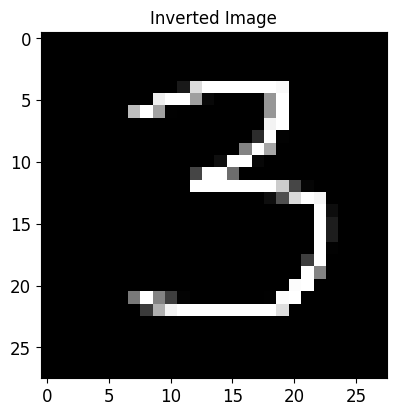

In [ ]:

# Load the image
image = cv2.imread('/content/download (4).png')

# Resize the image to 28x28 pixels
resized_image = cv2.resize(image, (28, 28))

# Convert the image to grayscale
gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

# Invert the grayscale image
inverted_image = 255 - gray_image

# Flatten the inverted image to a 1D array
flattened_image = inverted_image.flatten()

# Reshape the flattened image into a 2D array with a single sample
sample = flattened_image.reshape(1, -1)

# Predict using the trained perceptron model
# prediction = bin_clf.predict(sample)
prediction = clf.predict(sample)
# print(type(prediction))
# print(str(prediction[0])=='1.0')
if str(prediction[0])=='1.0':
  result = 'Zero Detected'
else:
  result = 'Non-Zero'
print(result)
print("Predicted digit:", prediction)

# Plot the inverted image as a vector of pixel values
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(inverted_image, cmap='gray')
plt.title('Inverted Image')



plt.tight_layout()
plt.show()

In [ ]:
# import joblib
# joblib.dump(clf, 'perceptron_model.pkl')
import pickle
with open('perceptron_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [ ]:
# get the prepdiction for all training samples
y_hat = clf.predict(x_train)

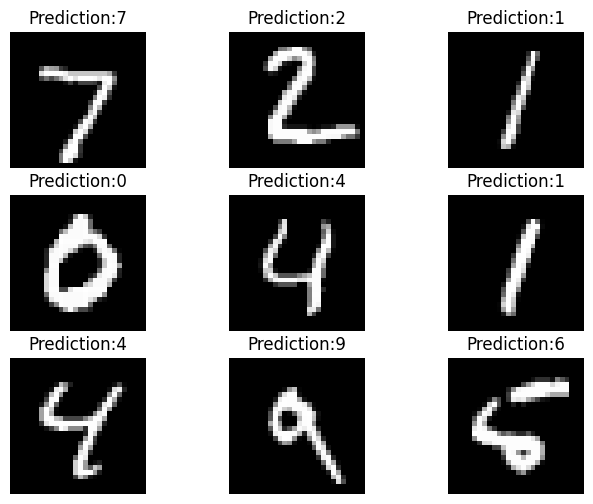

In [ ]:
y_hat_test_0 = clf.predict(x_test)
num_images = 9
factor = np.int64(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset = 0
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(x_test[index+j].reshape(28,28),cmap='gray')

    ax[i,j].set_title('Prediction:{0}'.format(str(y_hat_test_0[index+j])))
    ax[i,j].set_axis_off()

In [ ]:
print(classification_report(y_train,y_hat))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      5923
           1       0.94      0.98      0.96      6742
           2       0.89      0.90      0.90      5958
           3       0.86      0.87      0.87      6131
           4       0.89      0.94      0.91      5842
           5       0.81      0.88      0.85      5421
           6       0.92      0.97      0.94      5918
           7       0.91      0.94      0.92      6265
           8       0.92      0.77      0.84      5851
           9       0.92      0.82      0.87      5949

    accuracy                           0.90     60000
   macro avg       0.90      0.90      0.90     60000
weighted avg       0.91      0.90      0.90     60000



Let us display the confusion matrix and relate it with the report above.

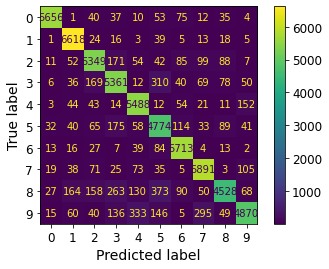

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train,y_hat,values_format='.5g') # it return matplotlin plot object

* What are all the insights we could infer from the above figure?
* Digit 2 is often confused with Digit 3 (Reasonable!).

In [ ]:

# Load the image
image = cv2.imread('/content/Annotation 2024-04-26 043859.jpg')

# Resize the image to 28x28 pixels
resized_image = cv2.resize(image, (28, 28))

# Convert the image to grayscale
gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

# Invert the grayscale image
inverted_image = 255 - gray_image

# Flatten the inverted image to a 1D array
flattened_image = inverted_image.flatten()

# Reshape the flattened image into a 2D array with a single sample
sample = flattened_image.reshape(1, -1)

# Predict using the trained perceptron model
prediction = clf.predict(sample)
# print(type(prediction))
# print(str(prediction[0])=='1.0')
if str(prediction[0])=='1.0':
  result = 'Zero Detected'
else:
  result = 'Non-Zero'
print(result)
print("Predicted digit:", prediction[0])

# Plot the inverted image as a vector of pixel values
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(inverted_image, cmap='gray')
plt.title('Inverted Image')



plt.tight_layout()
plt.show()
